# Using shadow classes in Python

This notebook explains how to create and use GridLAB-D shadow classes in Python.  The purpose of a shadow class is to provide high-performance access to specific properties of a GridLAB-D class by wrapping it in a Python class that contains the needed properties of the GridLAB-D class.  GridLAB-D classes usually provide very large numbers of properties, many of which are not needed by a particular simulation.  By creating a shadow class, the Python code can limit the amount of data is must exchange with GridLAB-D and thus minimize the time required to communicate data between GridLAB-D and Python.

In the following tutorial we are going to implement a thermostat in Python for a GridLAB-D house object.  There are a number of steps required to accomplish this and we will go through each one step-by-step to ensure a full understanding of how and why it works.

The first step is to construct a baseline house model in San Francisco, California:

In [1]:
!cat models/house_0.glm

#input "CA-San_Francisco_Intl_Ap.tmy3"
module residential;
object house
{
	parent "meter_0";
	name "house_0";
};


We then define a power source, which in this case is simple a residential meter:

In [2]:
!cat models/meter_0.glm

module powerflow;
object triplex_meter
{
	name "meter_0";
	phases AS;
	nominal_voltage 120;
	measured_energy_delta_timestep 1 h;
}


We now define two recorders to collect the house air temperature and the metered real interval energy and generate plots from them:

In [3]:
!cat models/record_0.glm

module tape
{
	csv_header_type NAME;
}
object recorder
{
	parent "house_0";
	property "air_temperature[degF],system_mode";
	interval -1;
	file "house_0_temperature.csv";
	line_units NONE;
};
#output "house_0_temperature.png" -t csvplot
object recorder
{
	parent "meter_0";
	property "measured_real_energy_delta[kWh]";
	interval 1 h;
	file "meter_0_energy.csv";
	line_units NONE;
};
#output "meter_0_energy.png" -t csvplot


Finally, we combine these together in a model to simulate one year:

In [4]:
!cat models/model_0.glm

clock 
{
	timezone "PST+8PDT";
	starttime "2020-01-01 00:00:00 PST";
	stoptime "2021-01-01 00:00:00 PST";
}
#include "meter_0.glm"
#include "house_0.glm"
#include "record_0.glm"


Now we can run the simulation and view the results

In [5]:
!gridlabd -W models model_0.glm

WARNING  [INIT] : house:2: ELCAP2010 implicit enduse data is not valid for individual enduses
WARNING  [2021-01-01 00:00:00 PST] : last warning message was repeated 9 times


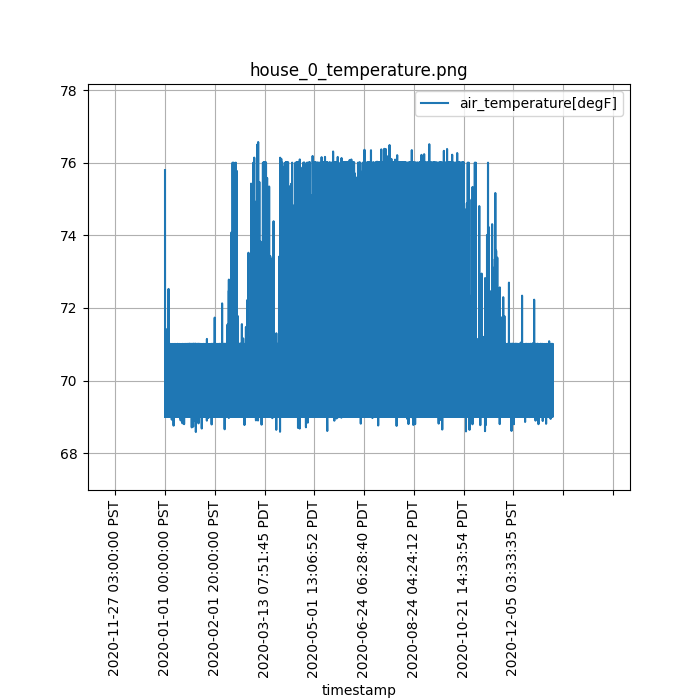

In [6]:
from IPython.display import Image
Image("models/house_0_temperature.png")

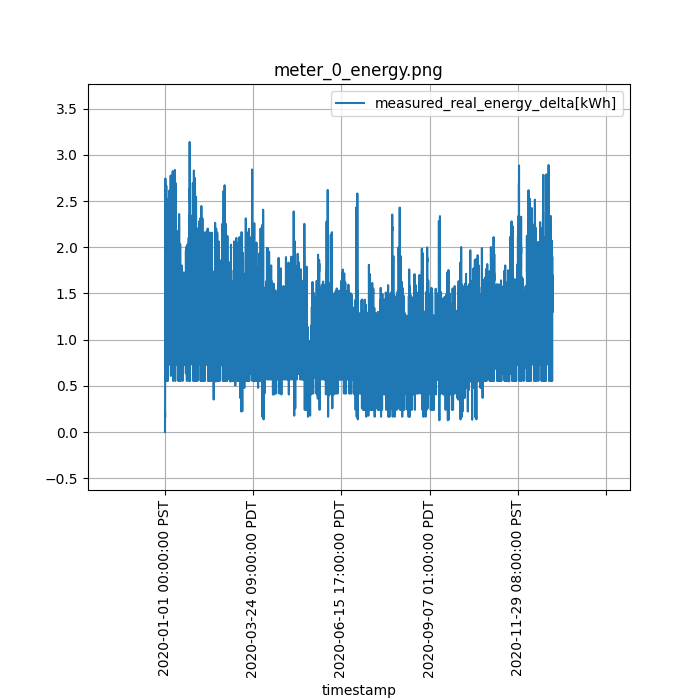

In [7]:
Image("models/meter_0_energy.png")

Now we construct our study house with its link to an external thermostat:

In [22]:
!cat models/house_1.glm

#input "CA-San_Francisco_Intl_Ap.tmy3"
module residential;
#set pythonpath=.
module thermostat;
object house
{
	parent "meter_1";
	name "house_1";
	on_init python:thermostat.setup;
	on_precommit python:thermostat.update;
};


The external thermostat is defined using the following python code:

In [20]:
!cat models/thermostat.py

import gridlabd
class thermostat:
	ts = 120 # thermostat update rate	
	def __init__(self,obj): # this links the thermostat to the house
		self.Tair = gridlabd.property(obj,"air_temperature")
		self.Theat = gridlabd.property(obj,"heating_setpoint")
		self.Tcool = gridlabd.property(obj,"cooling_setpoint")
		self.mode = gridlabd.property(obj,"system_mode")
		self.deadband = gridlabd.property(obj,"thermostat_deadband").get_value()
	def update(self): # this is the thermostat control strategu
		T = self.Tair.get_value()
		T0 = self.Theat.get_value() - self.deadband/2
		T1 = self.Tcool.get_value() + self.deadband/2
		if T < T0:
			self.mode.set_value('HEAT')
		elif T > T1:
			self.mode.set_value('COOL')
		else:
			self.mode.set_value('OFF')
thermostats = {} # cache list thermostats
def on_precommit(t):
	return int((int(t/thermostat.ts)+1)*thermostat.ts)
def setup(obj,t): # called to set up a new thermostat in a house
	thermostats[obj] = thermostat(obj)
	gridlabd.set_value(obj,"thermostat_cont

In [21]:
!gridlabd -W models model_1.glm

ERROR    [INIT] : python_embed_import(module='thermostat',path='model'): ModuleNotFoundError("No module named 'thermostat'")
ERROR    [INIT] : thermostat.py: python module import failed
ERROR    [INIT] : traceback context is 'thermostat.py'
ERROR    [INIT] : source/module.cpp(465): module 'thermostat' load failed - dlopen(thermostat.so, 1): image not found
house_1.glm(4): module 'thermostat' load failed, No such file or directory
FATAL    [INIT] : shutdown after command line rejected


In [17]:
Image("models/house_1_temperature.png")

FileNotFoundError: No such file or directory: 'models/house_1_temperature.png'

FileNotFoundError: No such file or directory: 'models/house_1_temperature.png'

<IPython.core.display.Image object>

In [12]:
Image("models/meter_1_energy.png")

FileNotFoundError: No such file or directory: 'models/meter_1_energy.png'

FileNotFoundError: No such file or directory: 'models/meter_1_energy.png'

<IPython.core.display.Image object>

Now we compare the total energy use

In [13]:
import pandas as pd
meter_0 = pd.read_csv("models/meter_0_energy.csv")["measured_real_energy_delta[kWh]"].sum()
meter_1 = pd.read_csv("models/meter_1_energy.csv")["measured_real_energy_delta[kWh]"].sum()
print(f"Meter 0: {meter_0:.0f} kWh")
print(f"Meter 1: {meter_1:.0f} kWh")

FileNotFoundError: [Errno 2] No such file or directory: 'models/meter_1_energy.csv'